In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt



# Load & Visualize Data

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


In [3]:
len(training_data), len(test_data)

(60000, 10000)

torch.Size([1, 28, 28]) 1


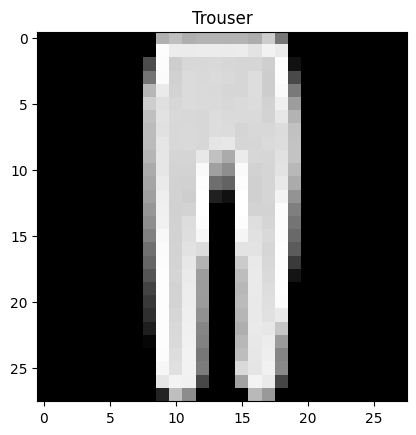

In [4]:
# Choose a random image
img, label = training_data[torch.randint(len(training_data), size=(1,)).item()]
print(img.shape, label)

# Map label to name
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Plot image
plt.title(labels_map[label])
plt.imshow(img.squeeze(), cmap="gray")

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Build a Neural Network

In [6]:
# Choose device for trainning, use some accelerator if available else use CPU
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


MPS is available and its Apples's equivalent of NVIDIA's CUDA. It allows pytorch to run on Apple's M series chips.

In [7]:
# Define neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Training Loop

We need:
1. Data -> comes from dataloader
2. Model -> structure defined by us
3. Loss Function -> Choose a loss function, for example CrossEntropyLoss
4. Optimizer -> Choose an optimizer, for example SGD

In [15]:
learning_rate = 1e-2
batch_size = 64
epochs = 10

In [16]:
# Training Loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    
# Test Loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

        


In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.974848  [    0/60000]
loss: 0.973072  [ 6400/60000]
loss: 0.943131  [12800/60000]
loss: 0.751179  [19200/60000]
loss: 0.916347  [25600/60000]
loss: 0.880011  [32000/60000]
loss: 0.716239  [38400/60000]
loss: 0.757687  [44800/60000]
loss: 0.680925  [51200/60000]
loss: 0.585602  [57600/60000]
Test Error: 
 Accuracy: 74.9%, Avg loss: 0.696563 

Epoch 2
-------------------------------
loss: 0.606556  [    0/60000]
loss: 0.730592  [ 6400/60000]
loss: 0.415060  [12800/60000]
loss: 0.616578  [19200/60000]
loss: 0.593869  [25600/60000]
loss: 0.564062  [32000/60000]
loss: 0.506796  [38400/60000]
loss: 0.518296  [44800/60000]
loss: 0.545215  [51200/60000]
loss: 0.456559  [57600/60000]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.592177 

Epoch 3
-------------------------------
loss: 0.466615  [    0/60000]
loss: 0.538791  [ 6400/60000]
loss: 0.503004  [12800/60000]
loss: 0.668113  [19200/60000]
loss: 0.379512  [25600/60000]
loss: 0.744295  [32000/600

# Save model

In [18]:
torch.save(model.state_dict(), "simple_configuration.pth")

# Predict

In [20]:
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [25]:
x, y = test_data[0][0], test_data[0][1]

In [26]:
x = x.unsqueeze(0).to(device)


In [30]:
with torch.no_grad(): 
    pred = model(x)
predicted_label = pred.argmax(1).item()

actual_label = y
print(f"Predicción: {labels_map[predicted_label]}, Real: {labels_map[actual_label]}")

Predicción: Ankle Boot, Real: Ankle Boot
